# Forecasting of Gasoline MED-FOB Price Based on Historical Data with Python

## Introduction

In [55]:
#Import necessary libraries
import warnings
import itertools
import pandas as pd

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson

In [56]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
print("Current size:", fig_size)

Current size: [15.0, 9.0]
Current size: [15, 9]


## Data Preparation 

In [57]:
#Import data set as pandas dataframe
df=pd.read_csv("Gasoline_Crack_2009_2017.csv")

In [58]:
#Convert date from text to datetime and check data frame
df['Date']=pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2273 entries, 0 to 2272
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2273 non-null   datetime64[ns]
 1   Gasoline_Crack  2273 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.6 KB


**Let's check first 5 rows of the data frame.** 

In [59]:
df.head()

,Date,Gasoline_Crack
0,2009-01-02,-1.06
1,2009-01-05,0.37
2,2009-01-06,1.82
3,2009-01-07,1.65
4,2009-01-08,3.94


In [60]:
data = pd.read_csv('Gasoline_Crack_2009_2017.csv', header = 0, index_col = 0, squeeze = True)

In [61]:
data.index = pd.to_datetime(data.index)

In [62]:
data.head()

Date
2009-01-02   -1.06
2009-01-05    0.37
2009-01-06    1.82
2009-01-07    1.65
2009-01-08    3.94
Name: Gasoline_Crack, dtype: float64

**Let's visualize the data as line plot.**

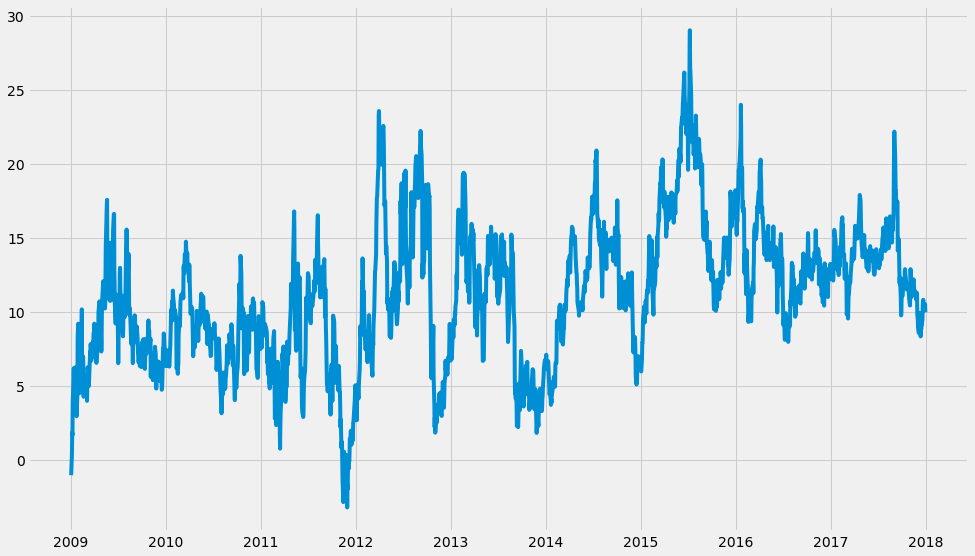

In [63]:
plt.plot(df['Date'],df['Gasoline_Crack'])

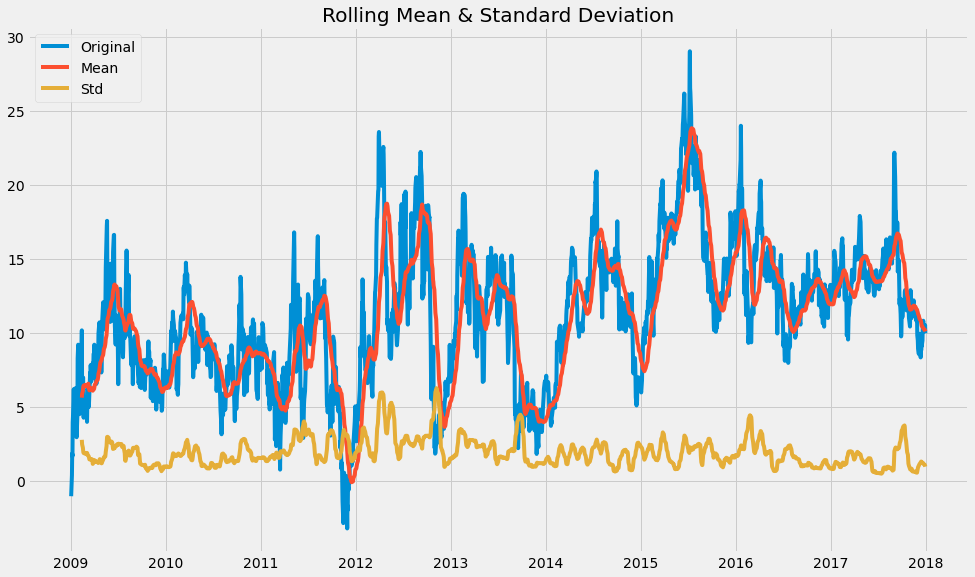

In [64]:
from statsmodels.tsa.stattools import adfuller

rolmean=df['Gasoline_Crack'].rolling(window=30,center=False).mean()
rolstd=df['Gasoline_Crack'].rolling(window=30,center=False).std()

plt.plot(df['Date'],df['Gasoline_Crack'])
plt.plot(df['Date'],rolmean)
plt.plot(df['Date'],rolstd)


plt.legend(['Original', 'Mean', 'Std'], loc='upper left')
plt.title('Rolling Mean & Standard Deviation')
plt.show() 

Stationary Test Continue - After seeing the mean and standard deviation do not change significantly; further testing (Augmented Dickey-Fuller Test) is applied

In [65]:
result = adfuller(df['Gasoline_Crack'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.141409
p-value: 0.000012
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Test MSE: 8.160
Prediction for next period: 10.086


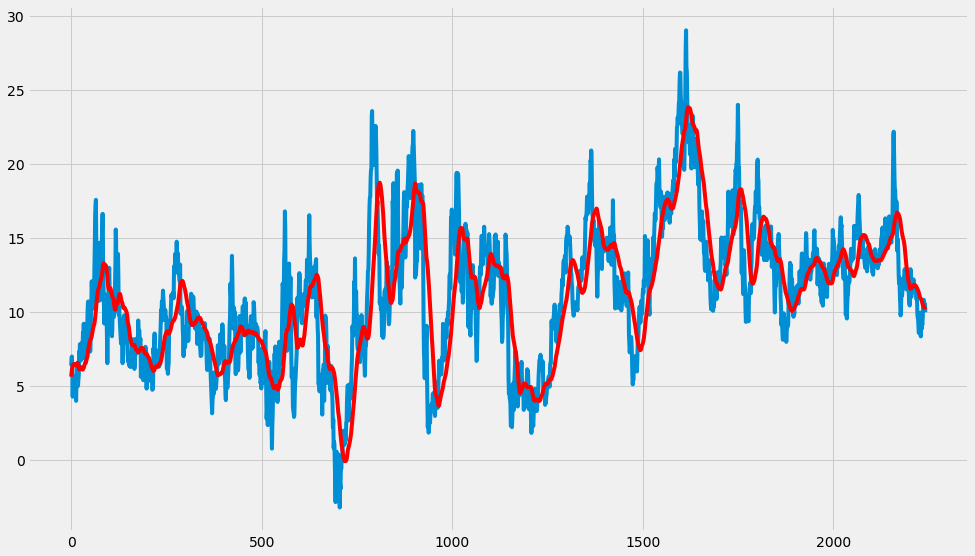

In [66]:
from sklearn.metrics import mean_squared_error
# prepare situation
X = df['Gasoline_Crack']
window = 30
history = [X[i] for i in range(window)]

test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('actual_value=%f, predicted=%f' % (obs, yhat))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print("Prediction for next period: {}".format(sum(history[-30:])/30))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show() 

Test MSE: 1.015
Prediction for next period: 9.96


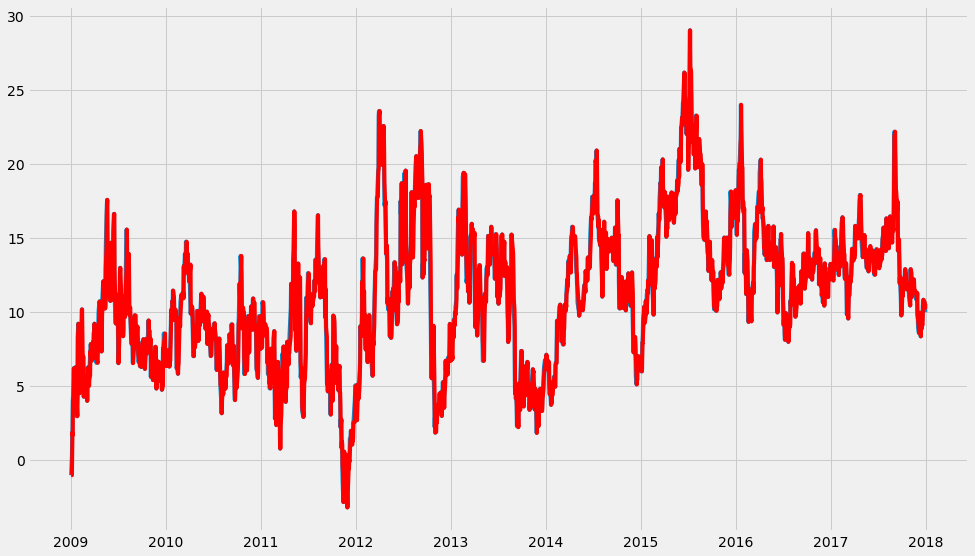

In [67]:
Y = df['Gasoline_Crack']
window = 2
history = [Y[i] for i in range(window)]
predictions=list()
predictions.append(history[0])
predictions.append(history[0])
test = [Y[i] for i in range(window, len(Y))]
alpha=1
# walk forward over time steps in test 
for t in range(len(test)):
    length = len(history)
    yhat = history[-1]*alpha+(1-alpha)*predictions[-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('actual_value=%f, predicted=%f' % (obs, predictions[-1]))
error = mean_squared_error(history, predictions)
print('Test MSE: %.3f' % error)
print("Prediction for next period: {}".format(history[-1]*alpha+(1-alpha)*predictions[-1]))

plt.plot(df['Date'],history)
plt.plot(df['Date'],predictions, color='red')
plt.show() 

Test MSE: 2.193
Prediction for next period: 10.363487553853824


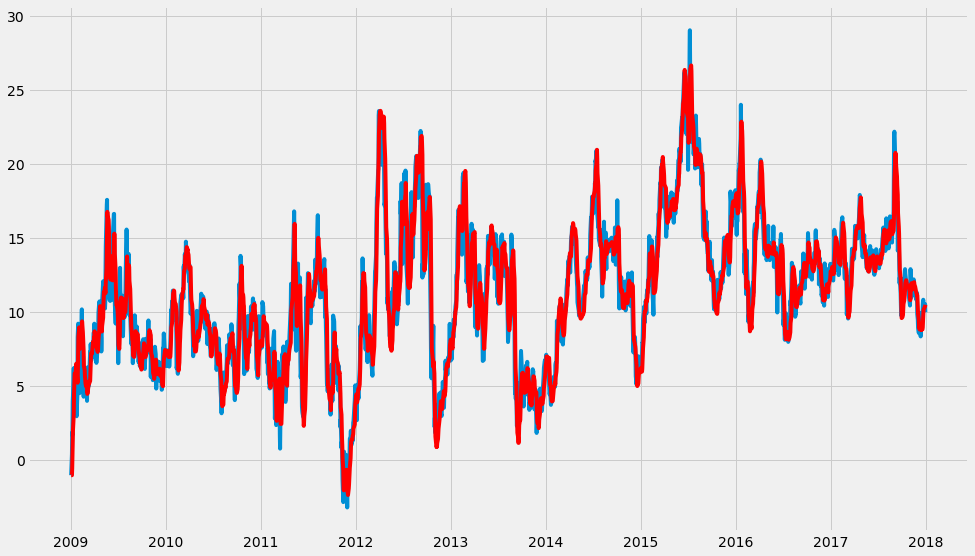

In [68]:
Y = df['Gasoline_Crack']
window = 2
history = [Y[i] for i in range(window)]
predictions=list()
predictions_l=list()
predictions_t=list()

predictions.append(history[0])
predictions.append(history[0])

predictions_l.append(history[0])
predictions_t.append(0)

test = [Y[i] for i in range(window, len(Y))]
alpha=0.3
beta=0.1
period=1

# walk forward over time steps in test 
for t in range(len(test)):
    length = len(history)
    lhat=history[-1]*alpha+(predictions_l[-1]+predictions_t[-1])*(1-alpha)
    predictions_l.append(lhat)
    that=(predictions_l[-1]-predictions_l[-2])*beta+predictions_t[-1]*(1-beta)    
    predictions_t.append(that)
    yhat = predictions_l[-1]+predictions_t[-1]*period
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('actual_value=%f, predicted=%f' % (obs, predictions[-1])) 
error = mean_squared_error(history, predictions)
print('Test MSE: %.3f' % error)
lhat=history[-1]*alpha+(predictions_l[-1]+predictions_t[-1])*(1-alpha)
predictions_l.append(lhat)
that=(predictions_l[-1]-predictions_l[-2])*beta+predictions_t[-1]*(1-beta)    
predictions_t.append(that)


print("Prediction for next period: {}".format(predictions_l[-1]+predictions_t[-1]*period))

plt.plot(df['Date'],history)
plt.plot(df['Date'],predictions, color='red')
plt.show()

In [69]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Gasoline_Crack'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.141409
p-value: 0.000012
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


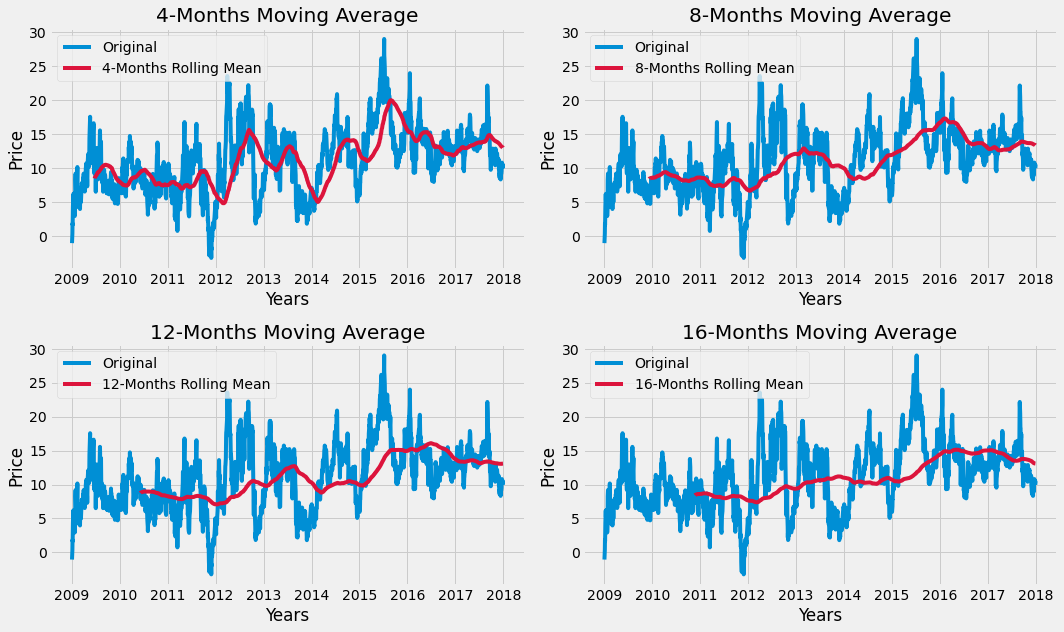

In [70]:
# define figure and axes
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False);
fig.set_figwidth(15);
fig.set_figheight(9);
y=data
# push data to each ax
#upper left
axes[0][0].plot(y.index, y, label='Original');
axes[0][0].plot(y.index, y.rolling(window=120).mean(), label='4-Months Rolling Mean', color='crimson');
axes[0][0].set_xlabel("Years");
axes[0][0].set_ylabel("Price");
axes[0][0].set_title("4-Months Moving Average");
axes[0][0].legend(loc='best');
 
# upper right
axes[0][1].plot(y.index, y, label='Original')
axes[0][1].plot(y.index, y.rolling(window=240).mean(), label='8-Months Rolling Mean', color='crimson');
axes[0][1].set_xlabel("Years");
axes[0][1].set_ylabel("Price");
axes[0][1].set_title("8-Months Moving Average");
axes[0][1].legend(loc='best');
 
# lower left
axes[1][0].plot(y.index, y, label='Original');
axes[1][0].plot(y.index, y.rolling(window=360).mean(), label='12-Months Rolling Mean', color='crimson');
axes[1][0].set_xlabel("Years");
axes[1][0].set_ylabel("Price");
axes[1][0].set_title("12-Months Moving Average");
axes[1][0].legend(loc='best');
 
# lower right
axes[1][1].plot(y.index, y, label='Original');
axes[1][1].plot(y.index, y.rolling(window=480).mean(), label='16-Months Rolling Mean', color='crimson');
axes[1][1].set_xlabel("Years");
axes[1][1].set_ylabel("Price");
axes[1][1].set_title("16-Months Moving Average");
axes[1][1].legend(loc='best');
plt.tight_layout();
plt.show()

In [71]:
#from pandas import Series
#series = Series.from_csv('Gasoline_Crack_2009_2017.csv', header=0)
#X = series.values
X=data.values
split = int((len(X) / 2))
X1= X[0:split] 
X2=X[split+1:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=9.314005, mean2=12.926417
variance1=18.992705, variance2=18.712366


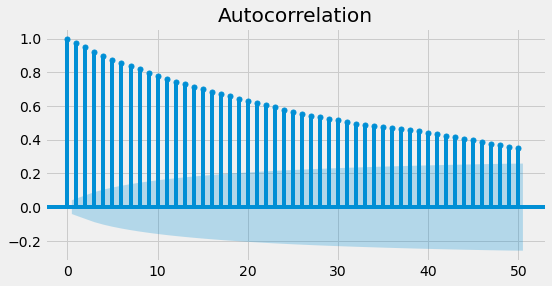

In [80]:
from pandas import Series

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data, lags=50)
fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.show()

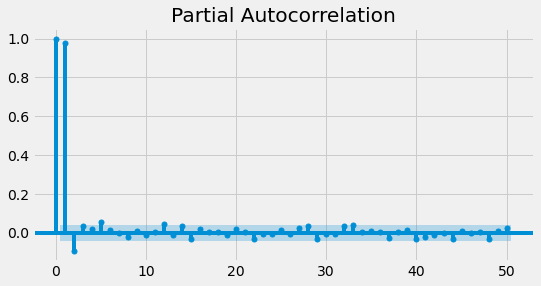

In [82]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data, lags=50)
fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.show()

In [26]:
resample = data.resample('M') #the 'M' groups the data in buckets by end of the month, if you want bucket by start of the month use 'MS'
monthly_mean = resample.mean()
print(monthly_mean.head(13))
number_sample=monthly_mean.shape[0]
number_sample

Date
2009-01-31     4.791429
2009-02-28     6.474000
2009-03-31     6.550000
2009-04-30     8.556500
2009-05-31    12.862105
2009-06-30    12.188182
2009-07-31    10.284783
2009-08-31    10.213000
2009-09-30     7.728636
2009-10-31     7.769091
2009-11-30     6.422381
2009-12-31     6.234762
2010-01-31     8.431000
Freq: M, Name: Gasoline_Crack, dtype: float64


108

In [27]:
#Create a training sample and testing sample before analyzing the series

number_data_train=int(0.95*number_sample+1)
number_data_forecast=number_sample-number_data_train
#timeseries_dataframe
ts_train=monthly_mean.iloc[:number_data_train]
ts_test=monthly_mean.iloc[number_data_train:]
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:","\n",ts_train.tail(),"\n")
print("Testing Series:","\n",ts_test.head())

(103,)
(5,)
Training Series: 
 Date
2017-03-31    12.270000
2017-04-30    15.893889
2017-05-31    13.743810
2017-06-30    13.429545
2017-07-31    14.269524
Freq: M, Name: Gasoline_Crack, dtype: float64 

Testing Series: 
 Date
2017-08-31    15.952727
2017-09-30    14.926190
2017-10-31    11.714545
2017-11-30    11.373636
2017-12-31     9.663684
Freq: M, Name: Gasoline_Crack, dtype: float64


In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [29]:
def model_resid_stats(model_results,verbose= True):
    het_method='breakvar'
    norm_method='jarquebera'
    sercor_method='ljungbox'
    
    (het_stat,het_p)=model_results.test_heteroskedasticity(het_method)[0]
    norm_stat,norm_p,skew,kurtosis=model_results.test_normality(norm_method)[0]
    sercor_stat,sercor_p=model_results.test_serial_correlation(sercor_method)[0]
    sercor_stat=sercor_stat[-1]#largest lag
    sercor_p=sercor_p[-1]#largest lag

    dw= durbin_watson(model_results.filter_results.standardized_forecasts_error[0])

    #check whether roots are outside the unit circle ( we want them to be)
    #will be True when AR is not used (i.e, AR order=0)
    arroots_outside_unit_circle=np.all(np.abs(model_results.arroots)>1)
    # will be True when MA is not used (i.e., MA order=0)
    maroots_outside_unit_circle=np.all(np.abs(model_results.maroots)>1)
    
    if verbose:
        print("Test heteroskedasticity of residuals ({}): stat={:.3f},p={:.3f}".format(het_method,het_stat,het_p))
        #print("\nTest normality of residuals {}: stat={:.3f},p={:.3f}").format(norm_method,norm_stat,norm_p)
        print("\nTest serial correlation ({}): stat={:.3f}, p={:.3f}".format(sercor_method,sercor_stat,sercor_p))
        print("\nTest for durbin watson (should be between 1-3):",dw)
        print("\nTest for all AR roots outside the unit circle (>1):",arroots_outside_unit_circle)
        print("\nTest for all MA roots outside the unit circle (>1):",maroots_outside_unit_circle)
    
    stat={'durbin_watson':dw,'het_method':het_method, 'het_stat': het_stat,'het_p':het_p,'norm_method': norm_method,'norm_stat':norm_stat,'norm_p':norm_p,'skew':skew,'kurtosis':kurtosis,'sercor_method':sercor_method,'sercor_stat':sercor_stat,'sercor_p':sercor_p,'arroots_outside_unit_circle':arroots_outside_unit_circle,'maroots_outside_unit_circle':maroots_outside_unit_circle}
    return stat

In [30]:
def model_gridsearch(ts,p_min,d_min,q_min,p_max,d_max,q_max,enforce_stationarity=True,enforce_invertibility=True,simple_differencing=False, plot_diagnostics=False,verbose=False,filter_warnings=True):
    cols=['p','d','q','enforce_stationarity','enforce_invertibility','simple_differencing','aic','bic','het_p','norm_p','secor_p','dw_stat','arroots_gt_1','maroots_gt_1','datetime_run']
    df_results=pd.DataFrame(columns=cols)
    mod_num=0
    for p,d,q in itertools.product(range(p_min,p_max+1),range(d_min,d_max+1),range(q_min,q_max+1)):
        this_model=pd.DataFrame(index=[mod_num],columns=cols)
        if p==0 and d==0 and q==0:
            continue
        try:
            model=sm.tsa.SARIMAX(ts,order=(p,d,q),enforce_stationarity=enforce_stationarity,enforce_invertibility=enforce_invertibility,simple_differencing=simple_differencing)
            #if filter_warnings is True:
                
                #with warnings.catch_warnings():
                    #warnings.filterwarning("ignore")
                    #model_results=model.fit(disp=0)
                    
            if True:
                model_results=model.fit()
            if verbose:
                print(model_results.summary())
            if plot_diagnostics:
                model_results.plot_diagnostics
            stat=model_resid_stats(model_results,verbose=verbose)
            
            this_model.loc[mod_num,'p']=p
            this_model.loc[mod_num,'d']=d
            this_model.loc[mod_num,'q']=q
            this_model.loc[mod_num,'enforce_stationarity']=enforce_stationarity
            this_model.loc[mod_num,'enforce_invertibility']=enforce_invertibility
            this_model.loc[mod_num,'simple_differencing']=simple_differencing
            this_model.loc[mod_num,'aic']=model_results.aic
            this_model.loc[mod_num,'bic']=model_results.bic
            this_model.loc[mod_num,'het_p']=stat['het_p']
            this_model.loc[mod_num,'norm_p']=stat['norm_p']
            this_model.loc[mod_num,'secor_p']=stat['sercor_p']
            this_model.loc[mod_num,'dw_stat']=stat['durbin_watson']
            this_model.loc[mod_num,'arroots_gt_1']=stat['arroots_outside_unit_circle']
            this_model.loc[mod_num,'maroots_gt_1']=stat['maroots_outside_unit_circle']
            
            this_model.loc[mod_num,'datetime_run']=pd.to_datetime('today').strftime('%Y-%m-%d')
            
            df_results=df_results.append(this_model)
            mod_num+=1    
        except:
            continue
    return df_results 

In [99]:
df_results=model_gridsearch(ts_train,0,0,0,2,2,2,enforce_stationarity=True,enforce_invertibility=True,simple_differencing=False, plot_diagnostics=False,verbose=False,filter_warnings=False)
df_results.sort_values(by='bic')

,p,d,q,enforce_stationarity,enforce_invertibility,simple_differencing,aic,bic,het_p,norm_p,secor_p,dw_stat,arroots_gt_1,maroots_gt_1,datetime_run
21,2,1,1,True,True,False,513.242,523.742,0.711234,0.679171,0.477565,2.02353,True,True,2021-01-28
13,1,1,2,True,True,False,514.024,524.524,0.698949,0.634522,0.39979,1.97505,True,True,2021-01-28
2,0,1,0,True,True,False,523.136,525.761,0.674799,0.123607,0.0530639,1.98356,True,True,2021-01-28
22,2,1,2,True,True,False,514.65,527.774,0.630558,0.675846,0.522803,1.99133,True,True,2021-01-28
25,2,2,2,True,True,False,516.052,529.128,0.699509,0.897166,0.578746,2.03598,True,True,2021-01-28
4,0,1,2,True,True,False,522.267,530.142,0.654467,0.58567,0.0177814,1.77909,True,True,2021-01-28
3,0,1,1,True,True,False,525.127,530.377,0.681427,0.117819,0.057885,2.00201,True,True,2021-01-28
11,1,1,0,True,True,False,525.13,530.38,0.679581,0.119337,0.056534,1.99694,True,True,2021-01-28
6,0,2,1,True,True,False,525.557,530.787,0.681401,0.176309,0.0613602,1.97964,True,True,2021-01-28
20,2,1,0,True,True,False,525.115,532.99,0.742918,0.198384,0.0962651,2.04764,True,True,2021-01-28


In [32]:
arima112=sm.tsa.SARIMAX(ts_train, order=(1,1,2))
model_results=arima112.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Gasoline_Crack   No. Observations:                  103
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -253.012
Date:                Thu, 28 Jan 2021   AIC                            514.024
Time:                        09:05:05   BIC                            524.524
Sample:                    01-31-2009   HQIC                           518.276
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5538      0.150      3.702      0.000       0.261       0.847
ma.L1         -0.7078      0.160     -4.414      0.000      -1.022      -0.393
ma.L2         -0.2207      0.126     -1.758      0.079      -0.467       0.025
sigma2         8.2775      1.231      6.722      0.000       5.864      10.691
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.95   Prob(JB):                         0.63
Heteroskedasticity (H):               1.14   Skew:                            -0.23
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

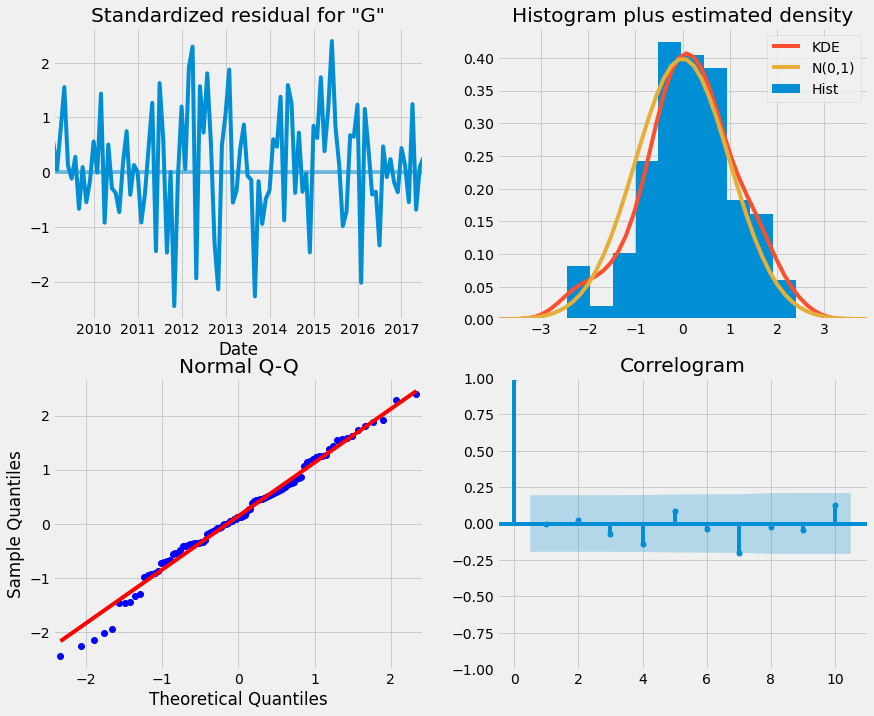

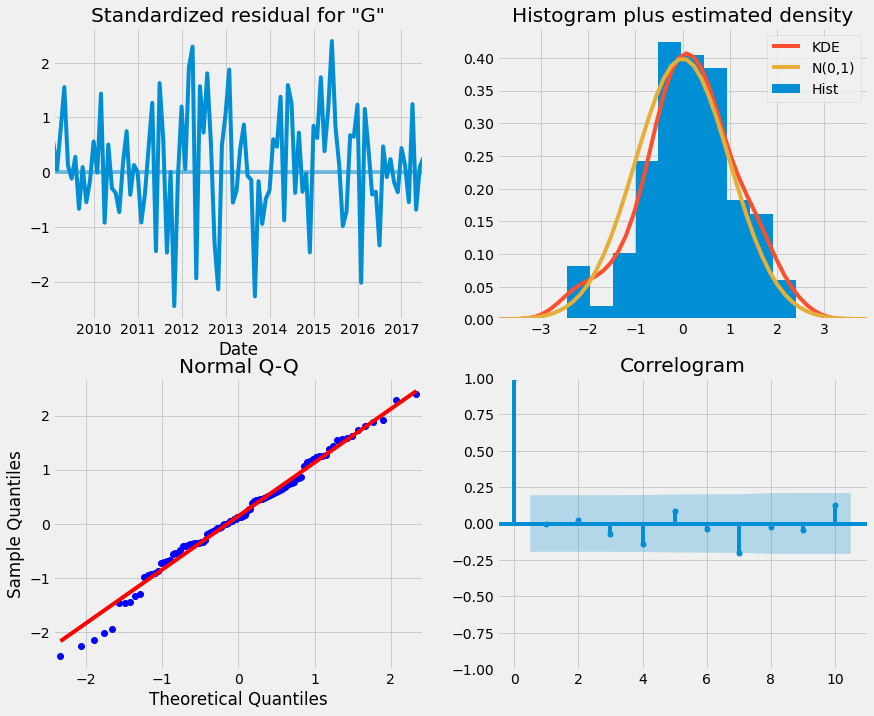

In [94]:
model_results.plot_diagnostics(figsize=(13,11))

In [95]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.93)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.SARIMAX(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.get_forecast(steps=1)
        yhat = yhat.predicted_mean
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 

resample = data.resample('M')
monthly_mean = resample.mean()
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
timeseries=monthly_mean.values
evaluate_models(timeseries, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=176.265
ARIMA(0, 0, 1) MSE=56.907
ARIMA(0, 0, 2) MSE=23.371
ARIMA(0, 1, 0) MSE=2.834
ARIMA(0, 1, 1) MSE=2.863
ARIMA(0, 1, 2) MSE=3.138
ARIMA(0, 2, 0) MSE=7.623
ARIMA(0, 2, 1) MSE=2.990
ARIMA(0, 2, 2) MSE=3.030
ARIMA(1, 0, 0) MSE=2.293
ARIMA(1, 0, 1) MSE=2.324
ARIMA(1, 0, 2) MSE=2.773
ARIMA(1, 1, 0) MSE=2.854
ARIMA(1, 1, 1) MSE=2.908
ARIMA(1, 1, 2) MSE=2.665
ARIMA(1, 2, 0) MSE=4.849
ARIMA(1, 2, 1) MSE=3.018
ARIMA(1, 2, 2) MSE=3.071
ARIMA(2, 0, 0) MSE=2.314
ARIMA(2, 0, 1) MSE=2.358
ARIMA(2, 0, 2) MSE=2.580
ARIMA(2, 1, 0) MSE=2.963
ARIMA(2, 1, 1) MSE=2.661
ARIMA(2, 1, 2) MSE=2.609
ARIMA(2, 2, 0) MSE=4.169
ARIMA(2, 2, 1) MSE=3.143
ARIMA(2, 2, 2) MSE=4.066
Best ARIMA(1, 0, 0) MSE=2.293


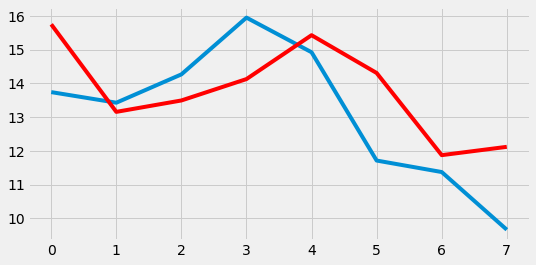

In [96]:
resample = data.resample('M')
monthly_mean = resample.mean()
order = (1,1,2)
X=monthly_mean.values

train_size = int(len(X) * 0.93)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.SARIMAX(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.get_forecast(steps=1)
    yhat = yhat.predicted_mean[0]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
plt.plot(test)
plt.plot(predictions, color='red')
fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.show()   

In [97]:
series= pd.read_csv('Gasoline_Crack_2009_2017.csv')
series['Date']=pd.to_datetime(series['Date'])
series['Month']=series['Date'].dt.month
series['Year'] = series['Date'].dt.year
series2= series.drop(['Date'],axis=1,inplace=False)
data1=series[series['Month']==1]['Gasoline_Crack']
data2=series[series['Month']==2]['Gasoline_Crack']
data3=series[series['Month']==3]['Gasoline_Crack']
data4=series[series['Month']==4]['Gasoline_Crack']
data5=series[series['Month']==5]['Gasoline_Crack']
data6=series[series['Month']==6]['Gasoline_Crack']
data7=series[series['Month']==7]['Gasoline_Crack']
data8=series[series['Month']==8]['Gasoline_Crack']
data9=series[series['Month']==9]['Gasoline_Crack']
data10=series[series['Month']==10]['Gasoline_Crack']
data11=series[series['Month']==11]['Gasoline_Crack']
data12=series[series['Month']==12]['Gasoline_Crack']
data_to_plot=[data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12]

Text(0, 0.5, 'Months')

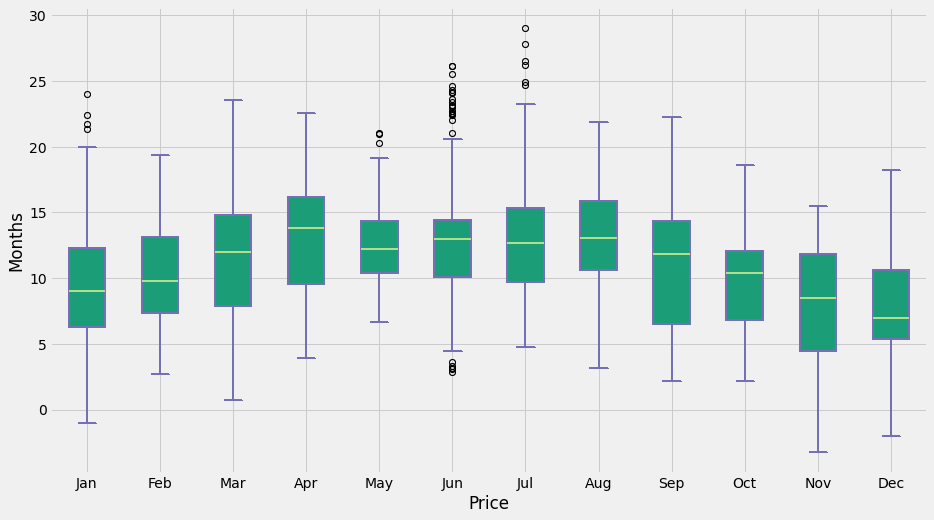

In [100]:
fig = plt.figure(1, figsize=(14, 8))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)

bp = ax.boxplot(data_to_plot, patch_artist=True)
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )
    
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
    
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)
    
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

xticks=np.arange(1, 13, 1)
    
ax.set_xticks(xticks) 
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xlabel('Price')
ax.set_ylabel('Months')